In [1]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [2]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/latest-run/files/weights_trained/epoch_150"

In [3]:
set_seed(0)
device = torch.device('cuda:0')
cose = CoSEModel('config.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [4]:
cose.encoder = cose.encoder.eval()
cose.decoder = cose.decoder.eval()
cose.embedding_predictive_model = cose.embedding_predictive_model.eval()
cose.position_predictive_model = cose.position_predictive_model.eval()

In [5]:
val_path = f"/data/{user}/cose/test/"

In [6]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "inputs_list_based.pkl",
                               "targets_file": "target_list_based.pkl"
                              }
                )

valid_loader = DataLoader(
                    dataset =batchdata,
                    batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])
log_dir = f'/home/ajimenez/pruebas'

In [7]:
for batch_input, batch_target in iter(valid_loader):
    break

In [8]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze()

enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = strok_len_inputs.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

target_ink = batch_target['t_target_ink'].squeeze(dim = 0).to(device)
target_strok_len = batch_target["seq_len"].squeeze(dim = 0)
target_pos = batch_target["start_coord"].squeeze(dim =  0)
target_strokes = batch_target["stroke"].squeeze(dim = 0)
#seq_len = target_strok_len.reshape(-1, num_strokes.max())

In [9]:
i_diagram = 0

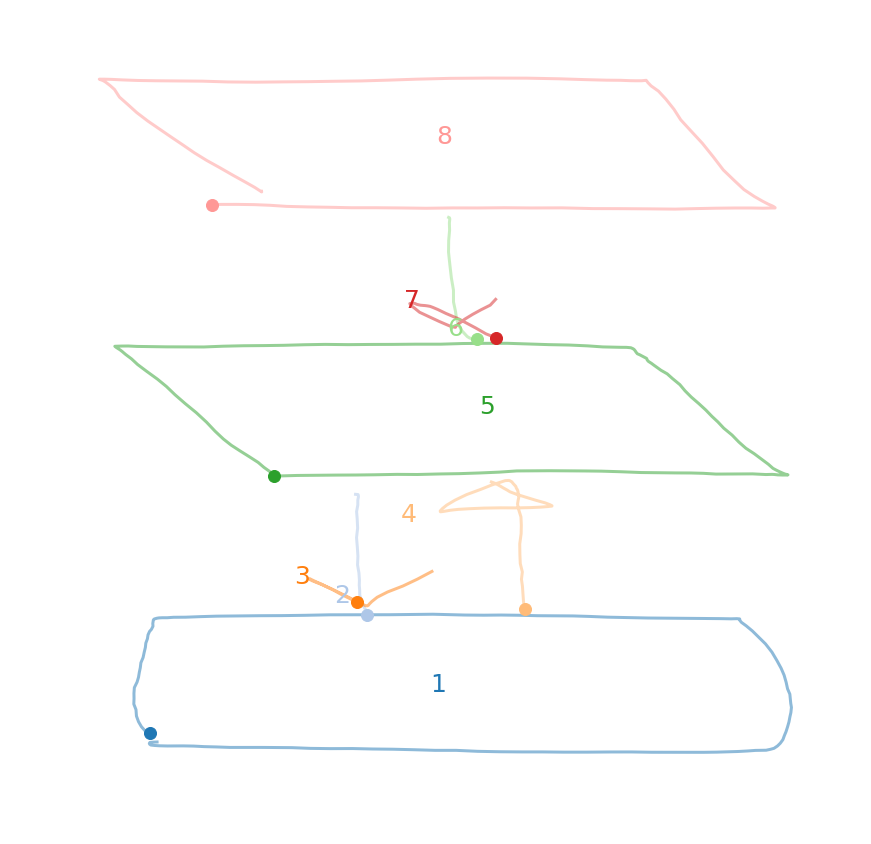

In [10]:
npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

In [11]:
encoder_inputs = encoder_inputs.to(device)
num_strokes = num_strokes.to(device)
strok_len_inputs = strok_len_inputs.to(device)
start_coord = start_coord.to(device)
end_coord = end_coord.to(device)
target_ink = target_ink.to(device)
target_strok_len = target_strok_len.to(device)
target_pos = target_pos.to(device)
target_strokes = target_strokes.to(device)

In [12]:
comb_mask, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,device, cose.config.enc_nhead)
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, comb_mask)

### decode_sequence

In [13]:
embedding = encoder_out.detach().clone()
seq_len = target_strok_len.detach().clone()

In [14]:
recon_stroke = decode_sequence(cose.decoder, embedding, seq_len, cose.device)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [15]:
target_strokes_list = batch_to_real_stroke_list(target_strokes, target_pos, seq_len, std_channel, mean_channel, cose.device)
recons_strokes_list = batch_to_real_stroke_list(recon_stroke, target_pos, seq_len, std_channel, mean_channel, cose.device)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

#### TODO: Undo preprocessing function

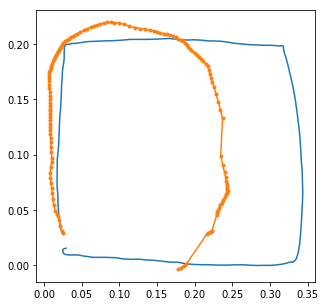

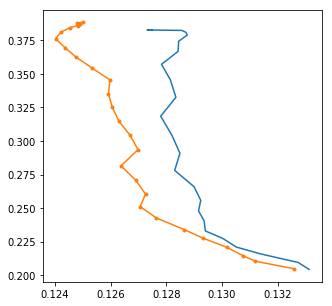

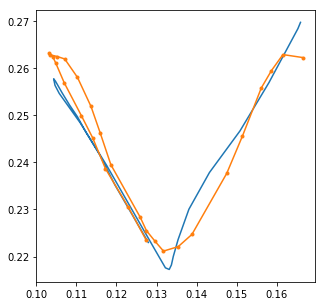

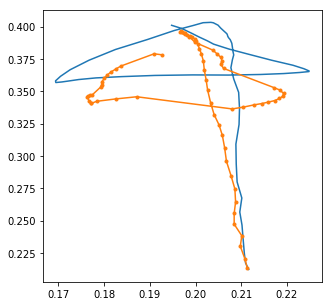

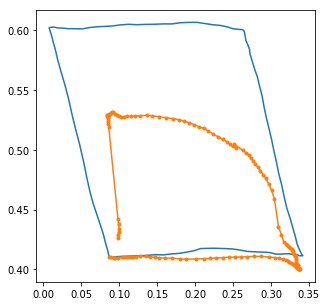

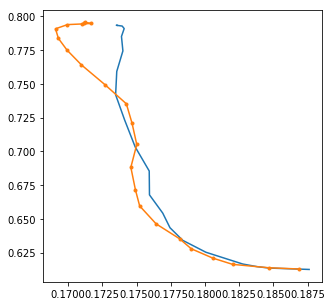

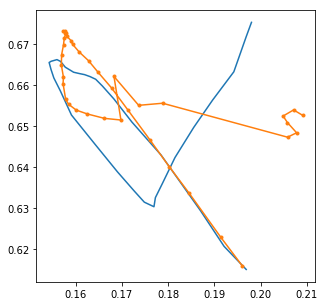

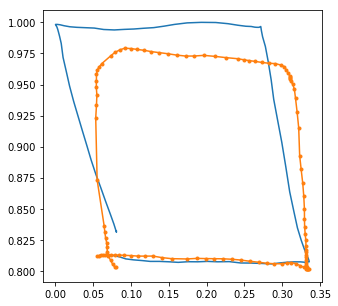

In [17]:
for i in range(recon_stroke.shape[0]):
    plt.figure(figsize = (5,5))
    plt.plot(target_strokes_list[i][:seq_len[i],0], target_strokes_list[i][:seq_len[i],1],'-')
    plt.plot(recons_strokes_list[i][:seq_len[i],0], recons_strokes_list[i][:seq_len[i],1],'.-')

### __predict_embedding_ordered_batch

In [18]:
given_strokes  = 2

In [20]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi, pred_emb, target_emb = predict_embedding_ordered_batch(cose.embedding_predictive_model, cose.device, embedding, start_coord, given_strokes = given_strokes, rel_nhead = cose.config.rel_nhead)

In [21]:
nll_embedingg_loss = -1*gmm.logli_gmm_logsumexp(target_emb, emb_pred_mu, emb_pred_sigma, emb_pred_pi)[:,0].detach().cpu().numpy()

#### __decode_embedding_all_components

In [22]:
all_pred_strokes, all_pred_stroke_lens, all_emb_pi, all_emb_samples = decode_embedding_all_components([cose.embedding_predictive_model, cose.decoder],emb_pred_mu, emb_pred_sigma, emb_pred_pi, seq_len, cose.device, given_strokes)

In [23]:
n_components = all_emb_pi.shape[1]
all_target_pos = target_pos[given_strokes:].repeat(n_components,1,1)

In [24]:
pred_strokes_list = batch_to_real_stroke_list(all_pred_strokes, all_target_pos, all_pred_stroke_lens, std_channel, mean_channel, cose.device)
target_pred_strokes_list = target_strokes_list[given_strokes:]*n_components

In [25]:
results_pred = evaluate_chamfer(pred_strokes_list, target_pred_strokes_list)

In [26]:
all_comp_chamfer = np.transpose(np.reshape(np.array(results_pred), [n_components, -1]), [1, 0])
min_chamfer = np.min(all_comp_chamfer, axis=1)
min_comp_id = np.argmin(all_comp_chamfer, axis=1)

In [28]:
best_embedding_idx = torch.vstack([torch.arange(all_emb_samples.shape[0]), torch.tensor(min_comp_id)]).T

In [29]:
best_embeddings = torch.stack([all_emb_samples[index][min_comp_id[index]] for index in range(all_emb_samples.size(0))])

In [30]:
min_comp_id = np.tile(min_comp_id[:, np.newaxis], [1, n_components])
sorted_comp_id = np.argsort(all_emb_pi)

# It is in ascending order.
ordered_min_comp_id = (n_components - np.argwhere(min_comp_id == sorted_comp_id))[:, 1] ## no se entiende para que se utiliza